In [5]:
import pennylane as qml
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import pandas as pd

In [11]:
def abs_error(m1,m2):
    return abs(m1 - m2)

def relative_error(m1,m2):
    return abs_error(m1,m2)/abs(m1)

def mse(m1,m2):
    return (m2 - m1) ** 2

def print_data(name, mean, true_mean, samples):
    return({'Name': name, 'Mean': mean, 'Absolute Error': abs_error(true_mean, mean), 'Relative Error': relative_error(true_mean, mean), 'MSE': mse(true_mean, mean), 'Samples': samples})

In [12]:
def func_f(x):
    return np.sin(x) ** 2

true_mean = math.sinh(1) / math.exp(1)

def mc_mean(numSamples):
    sampleData: list = np.random.randn(numSamples, 1)
    values: list = func_f(sampleData)
    MCMean: float = np.mean(values)
    return print_data("MC Mean", MCMean, true_mean, numSamples)

In [31]:
mse_values = []
num_samples = []
data = []
variances = []

for i in range(5):
    samples = 10 ** i
    num_samples.append(samples)
    answer = mc_mean(samples)
    
    results = []
    for _ in range(5):
        result = mc_mean(samples)
        results.append(result['Mean']) 
    variance = np.var(results)
       
    answer["Variance"] = variance
    
    data.append(answer)
    mse_values.append(answer.get('MSE'))

In [29]:
df = pd.DataFrame(data) 
print(df)
# print(df.to_latex(index=False, float_format="%.4f"))

      Name      Mean  Absolute Error  Relative Error           MSE  Samples  \
0  MC Mean  0.984116        0.551783        1.276294  3.044649e-01        1   
1  MC Mean  0.451571        0.019238        0.044499  3.701063e-04       10   
2  MC Mean  0.467967        0.035635        0.082424  1.269824e-03      100   
3  MC Mean  0.431645        0.000688        0.001590  4.727139e-07     1000   
4  MC Mean  0.429602        0.002730        0.006315  7.452815e-06    10000   

   Variance  
0  0.128016  
1  0.014436  
2  0.002545  
3  0.000164  
4  0.000007  


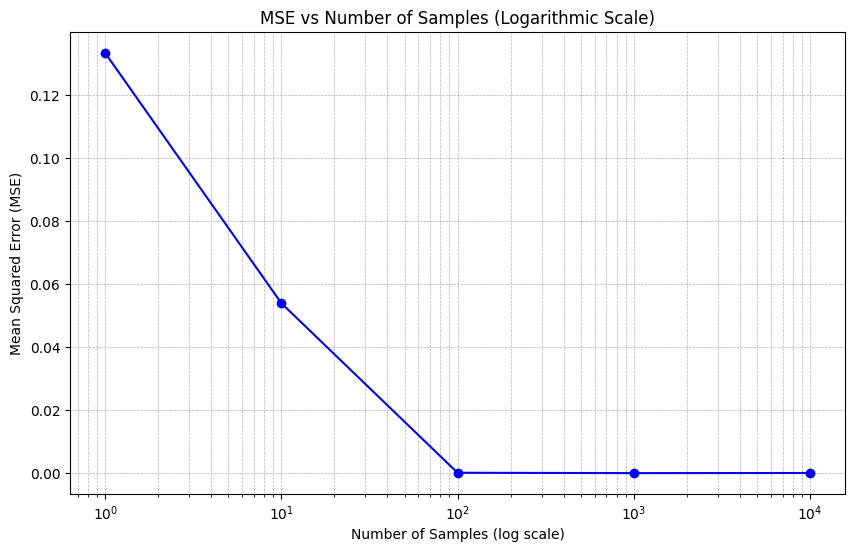

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(num_samples, mse_values, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Number of Samples (Logarithmic Scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [18]:
m = 5
M = 2 ** m
xmax = np.pi  # bound to region [-pi, pi]
xs = np.linspace(-xmax, xmax, M)

probs = np.array([norm().pdf(x) for x in xs])
probs /= np.sum(probs)

In [21]:
def func(i):
    return np.sin(xs[i]) ** 2

mse_values = []
num_samples = []
data = []
for n in range(1, 6):
    num_samples.append(n)
    N = 2 ** n

    target_wires = range(m + 1)
    estimation_wires = range(m + 1, n + m + 1)

    dev = qml.device("default.qubit", wires=(n + m + 1))

    @qml.qnode(dev)
    def circuit():
        qml.templates.QuantumMonteCarlo(
            probs,
            func,
            target_wires=target_wires,
            estimation_wires=estimation_wires,
        )
        return qml.probs(estimation_wires)

    results = []
    for _ in range(5):
        qmc_probs = circuit()
        phase_estimated = np.argmax(circuit()[:int(N / 2)]) / N
        answer = (1 - np.cos(np.pi * phase_estimated)) / 2
        results.append(answer)
    variance = np.var(results)
    
    format_data = print_data("QMC",answer,true_mean, n )
    format_data["Variance"] = variance
    
    mse_values.append(format_data.get("MSE"))
    data.append(format_data)
    


In [20]:
df = pd.DataFrame(data) 
print(df)

  Name      Mean  Absolute Error  Relative Error       MSE  Samples  \
0  QMC  0.000000        0.432332        1.000000  0.186911        1   
1  QMC  0.146447        0.285886        0.661264  0.081731        2   
2  QMC  0.308658        0.123674        0.286062  0.015295        3   
3  QMC  0.402455        0.029878        0.069108  0.000893        4   
4  QMC  0.450991        0.018659        0.043159  0.000348        5   

       Variance  
0  0.000000e+00  
1  0.000000e+00  
2  0.000000e+00  
3  0.000000e+00  
4  3.081488e-33  
